# Sentiment-Based Product Recommendation System

## Heroku Link: https://chandra-capstone-b3a6e671479f.herokuapp.com/

## 1. Business Problem Understanding

Ebuss is an e-commerce company operating in multiple product categories.
The goal of this project is to improve product recommendations by
combining:
1. Sentiment analysis on customer reviews
2. Collaborative filtering–based recommendation systems

The final system recommends products that are not only relevant
based on ratings but also positively perceived by users.


## 2. Data Loading & Overview

In [1]:
import pandas as pd

df = pd.read_csv("data/sample30.csv")
df.head()


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [2]:
df.shape

(30000, 15)

### Dataset Overview
- Number of users
- Number of products
- Number of reviews
- Key columns used in this project


In [3]:
print("Number of users:", df.reviews_username.nunique())
print("Number of products:", df.name.nunique())
print("Number of reviews:", df.shape[0])

Number of users: 24914
Number of products: 271
Number of reviews: 30000


## 3. Data Cleaning and Pre-Processing

In this section, we perform data quality checks including:
- Removing irrelevant columns
- Missing value treatment
- Correcting datatypes


### 3.1. Dropping Irrelevant Columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [5]:
# Initial Missing Value Inspection (Before Dropping Columns)
df.isnull().sum().sort_values(ascending=False)

reviews_userProvince    29830
reviews_userCity        28071
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_title             190
manufacturer              141
reviews_username           63
reviews_date               46
user_sentiment              1
id                          0
brand                       0
categories                  0
name                        0
reviews_rating              0
reviews_text                0
dtype: int64

The following columns will be dropped because they do not contribute to:
- sentiment analysis
- collaborative filtering–based recommendation
- deployment requirements

These include product metadata, URLs, identifiers, and location details,
which do not add value to the modeling objectives.


In [6]:
cols_to_drop = [
    'reviews_userCity',
    'reviews_userProvince',
    'reviews_date',
    'brand',
    'categories',
    'manufacturer',
    'asins',
    'upc',
    'ean',
    'imageURLs',
    'imageURLs_highRes',
    'keys',
    'sourceURLs'
]

# Drop only columns that actually exist (safety)
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   30000 non-null  object
 1   name                 30000 non-null  object
 2   reviews_didPurchase  15932 non-null  object
 3   reviews_doRecommend  27430 non-null  object
 4   reviews_rating       30000 non-null  int64 
 5   reviews_text         30000 non-null  object
 6   reviews_title        29810 non-null  object
 7   reviews_username     29937 non-null  object
 8   user_sentiment       29999 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.1+ MB


### 3.2. Missing Value Treatment

In [8]:
df.isnull().sum().sort_values(ascending=False)

reviews_didPurchase    14068
reviews_doRecommend     2570
reviews_title            190
reviews_username          63
user_sentiment             1
id                         0
name                       0
reviews_rating             0
reviews_text               0
dtype: int64

Missing Value Treatment Strategy

- reviews_didPurchase: Drop Column - Not required for sentiment or recommendation
- reviews_doRecommend: Drop Column - Not required, recommendation is rating based
- reviews_title: Drop Column - Optional field, detailed review text is already present
- reviews_username: Drop Rows - Required field for recommendation system
- user_sentiment: Drop Rows - This is the target label and this can't be empty.


In [9]:
# Drop irrelevant columns
df = df.drop(columns=[
    'reviews_didPurchase',
    'reviews_doRecommend',
    'reviews_title'
])

In [10]:
# Drop rows with missing critical values
df = df.dropna(subset=[
    'reviews_username',
    'user_sentiment'
])

In [11]:
df.isnull().sum()

id                  0
name                0
reviews_rating      0
reviews_text        0
reviews_username    0
user_sentiment      0
dtype: int64

Missing value analysis revealed that certain columns such as
`reviews_didPurchase`, `reviews_doRecommend`, and `reviews_title`
contained a significant number of missing values and were not relevant
to sentiment analysis or the recommendation system. Hence, these
columns were dropped.

Rows with missing values in critical fields such as
`reviews_username` and `user_sentiment` were removed, as these
fields are essential for building recommendation systems and
training sentiment classification models. Imputation was not
appropriate for these fields.


### 3.3. Correcting datatypes

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29936 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                29936 non-null  object
 1   name              29936 non-null  object
 2   reviews_rating    29936 non-null  int64 
 3   reviews_text      29936 non-null  object
 4   reviews_username  29936 non-null  object
 5   user_sentiment    29936 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.6+ MB


#### Correct Datatype Strategy
- id, name, reviews_text, reviews_username: Convert to string (for safety)
- reviews_rating: Conversion not needed, already using correct data type
- user_sentiment: Must be converted to 0/1. 1 - Positive, 0 - Negative

In [13]:
# Converting datatype for string columns
str_cols = ['id',
            'name',
            'reviews_text',
            'reviews_username']
for col in str_cols:
    df[col] = df[col].astype(str)

In [14]:
df.user_sentiment.value_counts()

user_sentiment
Positive    26579
Negative     3357
Name: count, dtype: int64

The target variable `user_sentiment` originally contained
categorical values ('Positive' and 'Negative').
These should be converted into numerical form for model training,
where 1 represents Positive sentiment and 0 represents Negative
sentiment, following standard classification conventions.

In [15]:
df['user_sentiment'] = df['user_sentiment'].map({
    'Positive': 1,
    'Negative': 0
})

In [16]:
df.head()

,id,name,reviews_rating,reviews_text,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,joshua,1
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,dorothy w,1
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,dorothy w,1
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,I read through the reviews on here before look...,rebecca,0
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel cau...,walker557,0


## 4. Text Processing

Customer reviews are unstructured textual data.
Before applying machine learning models, the text needs to be cleaned
and standardised to remove noise and reduce dimensionality.

The following preprocessing steps are applied:
1. Lowercasing
2. Removing punctuation and special characters
3. Stopword removal
4. Lemmatization

In [17]:
# Import required libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download resources (run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chandrakommuri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chandrakommuri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/chandrakommuri/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [18]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [19]:
def clean_review_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

In [20]:
# Apply Cleaning to Review Text
df['clean_reviews_text'] = df['reviews_text'].apply(clean_review_text)

In [21]:
# Before vs After Text Cleaning
df[['reviews_text', 'clean_reviews_text']].head(5)

,reviews_text,clean_reviews_text
0,i love this album. it's very good. more to the...,love album good hip hop side current pop sound...
1,Good flavor. This review was collected as part...,good flavor review collected part promotion
2,Good flavor.,good flavor
3,I read through the reviews on here before look...,read review looking buying one couple lubrican...
4,My husband bought this gel for us. The gel cau...,husband bought gel u gel caused irritation fel...


## 5. Feature Extraction

Machine learning algorithms cannot work directly with textual data.
Therefore, the cleaned review text is converted into numerical
representations using feature extraction techniques.

In this project, TF-IDF (Term Frequency–Inverse Document Frequency)
vectorization is used, as it captures the importance of words while
reducing the impact of frequently occurring terms.m

In [22]:
# Define Features and Target
X = df['clean_reviews_text']
y = df['user_sentiment']

In [23]:
# Train–Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y # Maintains sentiment class balance
)

In [24]:
# Apply TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [25]:
# Verify Feature Shapes
X_train_tfidf.shape, X_test_tfidf.shape

((23948, 5000), (5988, 5000))

TF-IDF was chosen over Bag-of-Words because:
- It reduces the weight of commonly occurring words
- It highlights words that are important to specific reviews
- It performs well with linear models such as Logistic Regression
- It helps reduce noise in high-dimensional text data

In [26]:
import pickle

# Generating pickle for TF-IDF Vectorizer
with open('pickles/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

## 6. Sentiment Model Building & Selection

- Check class imbalance

- Model Building - Build at least 3 ML models

- Evaluate them using proper metrics

- Optionally tune hyperparameters

- Select ONE best model with strong justification

### 6.1. Check class imbalance

The sentiment distribution was analysed to check whether the data
is imbalanced. Since sentiment datasets often contain more positive
reviews than negative ones, it is important to evaluate models using
metrics such as Precision, Recall, and F1-score instead of accuracy alone.

In [27]:
import matplotlib.pyplot as plt

y.value_counts()

user_sentiment
1    26579
0     3357
Name: count, dtype: int64

In [28]:
y.value_counts(normalize=True) * 100

user_sentiment
1    88.786077
0    11.213923
Name: proportion, dtype: float64

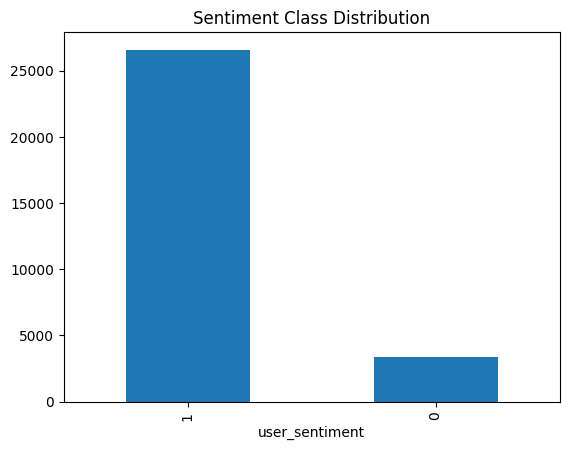

In [29]:
y.value_counts().plot(kind='bar', title='Sentiment Class Distribution')
plt.show()

The sentiment distribution shows a clear class imbalance, with
approximately 89% positive reviews and 11% negative reviews.
Such imbalance can lead models to favor the majority class.

Therefore, evaluation metrics such as Precision, Recall, and F1-score
are considered more reliable than accuracy alone.

In [30]:
# Import Evaluation Utilities
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### 6.2. Model Building

**Model 1 – Logistic Regression**

To address the observed class imbalance, class weights were used while
training Logistic Regression. Setting `class_weight='balanced'` assigns
higher importance to the minority class, ensuring that misclassification
of negative reviews is penalized more during training. This helps the
model achieve a better balance between Precision and Recall without
altering the original data distribution.m

In [31]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)
lr.fit(X_train_tfidf, y_train)

y_pred_lr = lr.predict(X_test_tfidf)

print("Logistic Regression Performance")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Performance
              precision    recall  f1-score   support

           0       0.53      0.91      0.67       671
           1       0.99      0.90      0.94      5317

    accuracy                           0.90      5988
   macro avg       0.76      0.90      0.80      5988
weighted avg       0.94      0.90      0.91      5988



**Interpretation:**
Logistic Regression with class weight balancing achieved strong
performance on the imbalanced sentiment dataset. The model was able
to correctly identify a high proportion of negative reviews
(recall = 0.91), which is critical for sentiment analysis tasks.

At the same time, the model maintained excellent performance on
positive reviews (F1-score = 0.94). The overall weighted F1-score
of 0.91 indicates a good balance between Precision and Recall
across both classes.


**Model 2 – Multinomial Naive Bayes**

Multinomial Naive Bayes does not provide a direct mechanism to handle
class imbalance using class weights. The model internally learns class
prior probabilities from the training data.

Therefore, no explicit class weighting was applied for Naive Bayes,
and model performance was evaluated using Precision, Recall, and F1-score.m

In [32]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

y_pred_nb = nb.predict(X_test_tfidf)

print("Naive Bayes Performance")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Performance
              precision    recall  f1-score   support

           0       0.55      0.12      0.19       671
           1       0.90      0.99      0.94      5317

    accuracy                           0.89      5988
   macro avg       0.72      0.55      0.57      5988
weighted avg       0.86      0.89      0.86      5988



**Interpretation:** Multinomial Naive Bayes achieved high accuracy due to its strong
performance on the majority class (positive sentiment). However,
it performed poorly on the minority class, with a recall of only 0.12
for negative reviews.

This indicates that the model fails to identify most negative sentiments,
making it unsuitable for this business problem. In contrast, Logistic
Regression achieved a much better balance between Precision and Recall
across both classes.

**Model 3 – Random Forest**

Random Forest provides support for handling class imbalance using
the `class_weight` parameter. However, due to the high dimensional
and sparse nature of TF-IDF features, Random Forest models tend
to overfit and are computationally expensive.


In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf.fit(X_train_tfidf, y_train)

y_pred_rf = rf.predict(X_test_tfidf)

print("Random Forest Performance")
print(classification_report(y_test, y_pred_rf))


Random Forest Performance
              precision    recall  f1-score   support

           0       0.88      0.64      0.74       671
           1       0.96      0.99      0.97      5317

    accuracy                           0.95      5988
   macro avg       0.92      0.81      0.86      5988
weighted avg       0.95      0.95      0.95      5988



**Interpretation:** Random Forest was trained with class weight balancing to address the
observed class imbalance in the sentiment dataset. The model achieved
strong overall performance, with a high weighted F1-score and accuracy.

For the majority class (positive sentiment), Random Forest performed
very well, achieving high precision and recall. The model also showed
an improvement in identifying negative sentiment compared to Naive
Bayes, indicating that class weighting helped mitigate imbalance issues.

However, despite these improvements, Random Forest achieved a lower
recall for the negative class compared to Logistic Regression. This
suggests that the model still misses a significant portion of negative
reviews, which is undesirable for this business use case.

Additionally, Random Forest models are computationally expensive and
prone to overfitting when applied to high-dimensional sparse TF-IDF
features.

#### Final Model Selection

Three models were evaluated for sentiment classification:
Logistic Regression, Multinomial Naive Bayes, and Random Forest.

Naive Bayes performed poorly on the minority class, identifying
only a small fraction of negative reviews. Random Forest improved
minority class performance but showed lower recall compared to
Logistic Regression and posed a higher risk of overfitting due to
the high-dimensional sparse TF-IDF features.

Logistic Regression with class weight balancing achieved the best
trade-off between Precision and Recall, particularly excelling in
identifying negative sentiment (recall = 0.91). Additionally, it
is computationally efficient, interpretable, and well-suited for
text classification tasks.

Hence, **Logistic Regression** was selected as the final sentiment
classification model for this project.

In [34]:
# Generating the pickle file with LogisticRegression model
with open('pickles/sentiment_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

## 7. Recommendation System

In this section, collaborative filtering techniques will be used to
recommend products to users based on historical rating patterns.
Two approaches are explored:
1. User-based Collaborative Filtering
2. Item-based Collaborative Filtering


In [35]:
def train_test_split_recommender(data, test_size=0.2):
    train_list = []
    test_list = []

    for user, user_data in data.groupby('reviews_username'):
        if len(user_data) < 2:
            train_list.append(user_data)
            continue

        test_count = max(1, int(len(user_data) * test_size))
        user_data = user_data.sample(frac=1, random_state=42)

        test_list.append(user_data.iloc[:test_count])
        train_list.append(user_data.iloc[test_count:])

    train_df = pd.concat(train_list)
    test_df = pd.concat(test_list)

    return train_df, test_df

In [36]:
train_df, test_df = train_test_split_recommender(df, test_size=0.2)

The dataset was split into training and testing sets to evaluate
the performance of the recommendation systems. The training set
was used to build the recommendation models, while the test set
was used for evaluation.

A user-wise train–test split was performed so that each user retained
at least one interaction in the training set. This is necessary for
collaborative filtering models, as random row-wise splitting can result
in users with no training history, making recommendation impossible.


In [37]:
# Create User–Item Matrix
train_user_item_matrix = train_df.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating',
    aggfunc='mean'
)

In [38]:
train_user_item_matrix.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
train_user_item_matrix.shape

(24914, 267)

In [40]:
train_user_item_matrix_filled = train_user_item_matrix.fillna(0)

Missing values represent products that a user has not rated.
These are filled with 0 to allow similarity computation.

In [41]:
train_user_item_matrix_filled.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 7.1. User-Based Collaborative Filtering

User-based collaborative filtering recommends products to a user
based on the preferences of similar users. Similarity between users
is computed using cosine similarity.

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(train_user_item_matrix_filled)
user_similarity_df = pd.DataFrame(
    user_similarity,
    index=train_user_item_matrix_filled.index,
    columns=train_user_item_matrix_filled.index
)

In [43]:
product_id_name_map = (
    df[['id', 'name']]
    .drop_duplicates()
    .set_index('id')['name']
    .to_dict()
)

In [44]:
def recommend_user_based(username, n_recommendations=20):
    if username not in train_user_item_matrix_filled.index:
        return pd.DataFrame(columns=['product_id', 'product_name', 'score'])

    # Get similarity scores of the given user with all other users
    similar_users = user_similarity_df[username].sort_values(ascending=False)[1:]

    # Compute weighted sum of ratings
    weighted_ratings = train_user_item_matrix_filled.loc[similar_users.index].T.dot(similar_users)

    # Remove products already rated by the user
    rated_products = train_user_item_matrix_filled.loc[username]
    rated_products = rated_products[rated_products > 0].index
    recommendations = weighted_ratings.drop(index=rated_products)

    # Take top N
    top_recommendations = recommendations.sort_values(ascending=False).head(n_recommendations)

    # Convert to DataFrame
    result = pd.DataFrame({
        'product_id': top_recommendations.index,
        'score': top_recommendations.values
    })

    # Map product names
    result['product_name'] = result['product_id'].map(product_id_name_map)

    # Reorder columns
    result = result[['product_id', 'product_name', 'score']]

    return result

In [45]:
recommend_user_based('00dog3').head(20)

,product_id,product_name,score
0,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,6.836597
1,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,4.637848
2,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,4.464737
3,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,3.674556
4,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),3.123475
5,AVpfN6Z71cnluZ0-gZmO,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",2.541278
6,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,2.096570
7,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,1.577986
8,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,1.577986
9,AVpe5s3RLJeJML43x4eA,Pantene Pro-V Expert Collection Age Defy Condi...,1.577986


It is acknowledged that different users may follow different rating
scales, where some users tend to give higher ratings and others are
more conservative. While user-based normalization techniques can be
used to address this bias in advanced recommender systems, raw ratings
were used in this project to maintain simplicity and interpretability.

Additionally, cosine similarity was used to compute similarities, which
is less sensitive to absolute rating scales and focuses on relative
rating patterns across users and items.


### 7.2. Item-Based Collaborative Filtering

Item-based collaborative filtering recommends products similar to
those the user has rated highly. Similarity is computed between items
instead of users.

In [46]:
item_similarity = cosine_similarity(train_user_item_matrix_filled.T)
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=train_user_item_matrix_filled.columns,
    columns=train_user_item_matrix_filled.columns
)

In [47]:
def recommend_item_based(username, n_recommendations=20):
    username = str(username).strip()

    if username not in train_user_item_matrix_filled.index:
        return pd.DataFrame(columns=['product_id', 'product_name', 'score'])

    # Ratings given by the user (only > 0)
    user_ratings = train_user_item_matrix_filled.loc[username]
    rated_products = user_ratings[user_ratings > 0].index

    if len(rated_products) == 0:
        return pd.DataFrame(columns=['product_id', 'product_name', 'score'])

    # Compute weighted similarity
    similarity_scores = item_similarity_df[rated_products]
    weighted_scores = similarity_scores.dot(user_ratings[rated_products])

    # Remove already rated products
    recommendations = weighted_scores.drop(index=rated_products)

    top_recommendations = recommendations.sort_values(
        ascending=False
    ).head(n_recommendations)

    result = pd.DataFrame({
        'product_id': top_recommendations.index,
        'score': top_recommendations.values
    })

    result['product_name'] = result['product_id'].map(product_id_name_map)

    return result[['product_id', 'product_name', 'score']]


In [48]:
recommend_item_based('00dog3')

,product_id,product_name,score
0,AVpfN6Z71cnluZ0-gZmO,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",0.117274
1,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,0.108973
2,AVpfAgSp1cnluZ0-b2-K,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",0.096136
3,AVpe5s3RLJeJML43x4eA,Pantene Pro-V Expert Collection Age Defy Condi...,0.086263
4,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,0.084167
5,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy Total Care Nourishi...,0.080633
6,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),0.068299
7,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,0.055425
8,AVpfluP1ilAPnD_xejxO,Stacy's Simply Naked Bagel Chips,0.039833
9,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,0.038820


In [49]:
def hit_rate_at_k(recommend_func, test_df, k=20):
    hits = 0
    total = 0

    for user in test_df['reviews_username'].unique():
        actual_items = test_df[test_df['reviews_username'] == user]['id'].values

        if len(actual_items) == 0:
            continue

        recommended_items = recommend_func(user, k)['product_id'].values

        if len(set(actual_items) & set(recommended_items)) > 0:
            hits += 1
        total += 1

    return hits / total if total > 0 else 0

In [50]:
# Ensure users in the test data are present in the training data.
valid_users = set(train_user_item_matrix_filled.index)
test_df_filtered = test_df[test_df['reviews_username'].isin(valid_users)]

For evaluation, the test dataset was filtered to include only users
present in the training data. This avoids cold-start scenarios, which
cannot be handled by collaborative filtering methods, and ensures
that hit rate is computed fairly.

In [51]:
user_based_hit_rate = hit_rate_at_k(recommend_user_based, test_df_filtered)
item_based_hit_rate = hit_rate_at_k(recommend_item_based, test_df_filtered)

user_based_hit_rate, item_based_hit_rate


(0.36159600997506236, 0.3081185924078692)

#### Comparison & Final Recommendation System Selection

The recommendation systems were evaluated using Hit Rate@20 on the test
dataset. User-based collaborative filtering achieved a slightly higher
hit rate compared to item-based filtering.

However, user-based methods are highly sensitive to changes in user
behavior and do not scale well as the number of users increases.
Item-based collaborative filtering, while achieving a marginally lower
hit rate, provides more stable and consistent recommendations and is
computationally more efficient.

Considering scalability, stability, and real-world applicability in an
e-commerce setting, **item-based collaborative filtering** is selected as
the final recommendation system.

In [52]:
# Generating the required pickle files
# Recommendation artifacts
with open('pickles/train_user_item_matrix_filled.pkl', 'wb') as f:
    pickle.dump(train_user_item_matrix_filled, f)

with open('pickles/item_similarity_df.pkl', 'wb') as f:
    pickle.dump(item_similarity_df, f)

with open('pickles/product_id_name_map.pkl', 'wb') as f:
    pickle.dump(product_id_name_map, f)

## 8. Top-20 Product Recommendations

Using the selected item-based collaborative filtering model, the
top 20 products are recommended for a given user based on historical
rating patterns.


In [53]:
username = '00dog3'  # replace with any valid username

top_20_recommendations = recommend_item_based(
    username,
    n_recommendations=20
)

top_20_recommendations

,product_id,product_name,score
0,AVpfN6Z71cnluZ0-gZmO,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",0.117274
1,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,0.108973
2,AVpfAgSp1cnluZ0-b2-K,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",0.096136
3,AVpe5s3RLJeJML43x4eA,Pantene Pro-V Expert Collection Age Defy Condi...,0.086263
4,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,0.084167
5,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy Total Care Nourishi...,0.080633
6,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),0.068299
7,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,0.055425
8,AVpfluP1ilAPnD_xejxO,Stacy's Simply Naked Bagel Chips,0.039833
9,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,0.038820


The item-based collaborative filtering model generates a ranked list
of products for the selected user by identifying items similar to
those the user has previously rated. The top 20 products with the
highest recommendation scores are presented as candidate products
for further refinement.

## 9. Fine-Tuning the Recommendation System and Recommendation of Top 5 Products


In [54]:
with open('pickles/sentiment_model.pkl', 'rb') as f:
    sentiment_model = pickle.load(f)

with open('pickles/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

In [55]:
def get_positive_sentiment_score(reviews):
    """
    reviews: list of review texts
    returns: average positive sentiment probability
    """
    if len(reviews) == 0:
        return 0

    reviews_clean = reviews.apply(clean_review_text)
    reviews_tfidf = tfidf_vectorizer.transform(reviews_clean)

    # Probability of Positive class (label = 1)
    positive_probs = sentiment_model.predict_proba(reviews_tfidf)[:, 1]

    return positive_probs.mean()


In [56]:
def sentiment_based_top5(recommendations_df):
    sentiment_scores = []

    for _, row in recommendations_df.iterrows():
        product_id = row['product_id']
        product_name = row['product_name']

        product_reviews = df[df['id'] == product_id]['reviews_text']

        score = get_positive_sentiment_score(product_reviews)

        sentiment_scores.append({
            'product_id': product_id,
            'product_name': product_name,
            'sentiment_score': score
        })

    sentiment_df = pd.DataFrame(sentiment_scores)

    # Sort by sentiment score
    top_5 = sentiment_df.sort_values(
        by='sentiment_score',
        ascending=False
    ).head(5)

    return top_5


In [57]:
# Step 1: Get Top-20 recommendations (item-based)
top_20 = recommend_item_based('00dog3', n_recommendations=20)

# Step 2: Filter Top-5 using sentiment
top_5_sentiment = sentiment_based_top5(top_20)

top_5_sentiment


,product_id,product_name,sentiment_score
19,AVpfRkzN1cnluZ0-hmnu,Smead174 2 1/4 Inch Accordion Expansion Wallet...,0.906448
9,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,0.851098
3,AVpe5s3RLJeJML43x4eA,Pantene Pro-V Expert Collection Age Defy Condi...,0.834813
12,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,0.795513
4,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,0.793390


### Sentiment-Based Recommendation Enhancement

After generating the top 20 product recommendations using the
item-based collaborative filtering approach, sentiment analysis
was applied to further refine the recommendations.

For each recommended product, all associated user reviews were
processed using the trained sentiment classification model to
predict positive sentiment probabilities. The average positive
sentiment score was computed for each product.

Finally, the top 5 products with the highest sentiment scores
were recommended to the user. This ensures that the final
recommendations are not only relevant based on past ratings but
also positively perceived by users.


## The application has been deployed at Heroku Link: https://chandra-capstone-b3a6e671479f.herokuapp.com/